In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn

from koopmann import aesthetics
from koopmann.data import (
    DatasetConfig,
    get_dataset_class,
)
from koopmann.models import MLP
from koopmann.models.utils import parse_safetensors_metadata
from koopmann.utils import (
    compute_model_accuracy,
)
from koopmann.visualization import plot_decision_boundary

%load_ext autoreload
%autoreload 2

In [2]:
model_name = "lotusroot_model"

In [3]:
file_path = f"/home/nsa325/work/koopmann/model_saves/{model_name}.safetensors"
model, _ = MLP.load_model(file_path)
model.eval()
model.summary()

Layer (type (var_name))                       Param #
MLP (MLP)                                     --
+ Sequential (_features)                      --
|    + LinearLayer (0)                        --
|    |    + Sequential (layers)               50
|    + LinearLayer (1)                        --
|    |    + Sequential (layers)               104
|    + LinearLayer (2)                        --
|    |    + Sequential (layers)               66
|    + LinearLayer (3)                        --
|    |    + Sequential (layers)               27
|    + LinearLayer (4)                        --
|    |    + Sequential (layers)               12
Total params: 259
Trainable params: 259
Non-trainable params: 0

In [4]:
# Dataset config
metadata = parse_safetensors_metadata(file_path=file_path)
print(metadata)
dataset_config = DatasetConfig(
    dataset_name=metadata["dataset"],
    num_samples=3_000,
    split="test",
    seed=42,
)
DatasetClass = get_dataset_class(name=dataset_config.dataset_name)
dataset = DatasetClass(config=dataset_config)

{'bias': 'True', 'config': '[10, 8, 6, 3]', 'dataset': 'LotusRootDataset', 'input_dimension': '2', 'nonlinearity': 'relu', 'output_dimension': '2'}


In [5]:
print(f"Testing Accuracy: {compute_model_accuracy(model, dataset)}")

Testing Accuracy: 0.9733333587646484


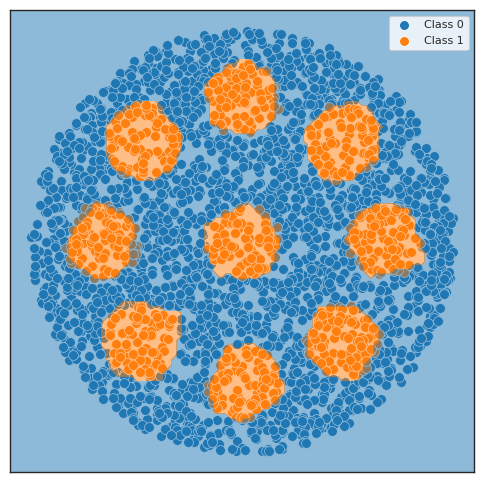

In [6]:
if dataset.in_features == 2:
    plot_decision_boundary(
        model,
        model.state_dict(),
        dataset.features,
        dataset.labels.squeeze(),
        labels=[0, 1, 2],
    )